__Goal__: Test inversion

    After simulate a source galaxy and deflect it, it's time to test the inversion!


In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_7/Simulation_Data/"

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)             #DM component

In [3]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

### Reading Data

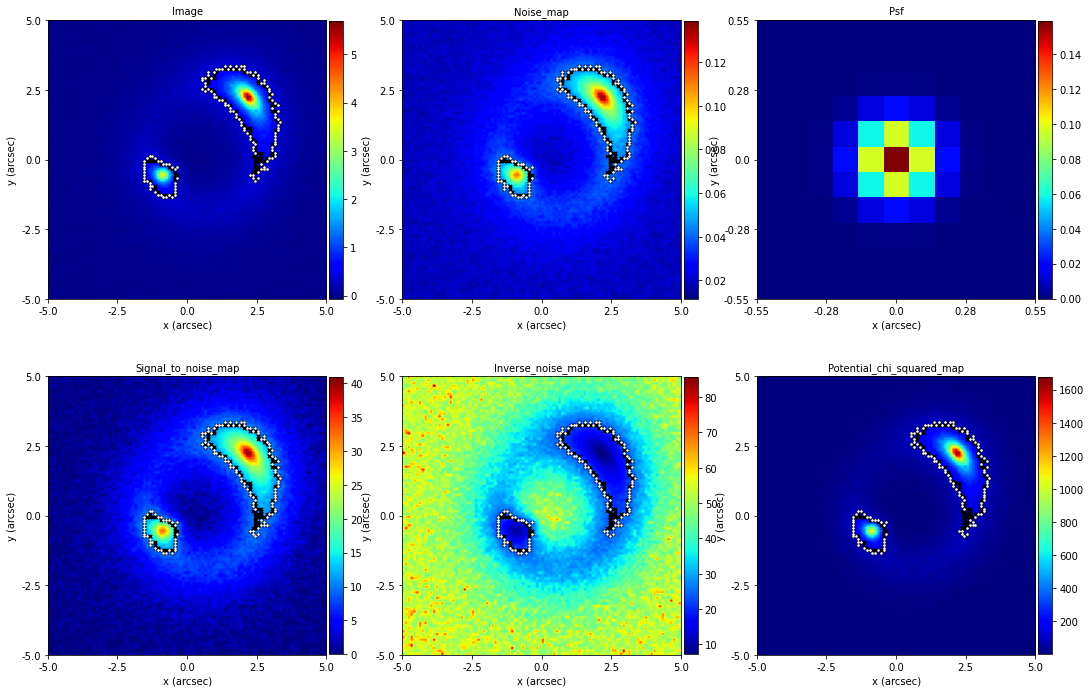

In [4]:
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/image.fits",
        noise_map_path=f"{data_folder}/noise_map.fits",
        psf_path=f"{data_folder}/psf.fits",
        pixel_scales=0.1,
        
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                    pixel_scales=imaging.pixel_scales)#You should check Mask_Maker folder before continue

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True),                         #Plot
)

In [5]:
masked_image.grid.shape

(673, 2)

## Starting model

In [6]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()
ell_comps = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW


#Components

mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh)
mass_profile.Analytic_Model(analytic_profile=eNFW)



#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

Finally, we're going to use our _Mapper_ to invert the image using an _Inversion_.

## Inversion with Fit Tracer

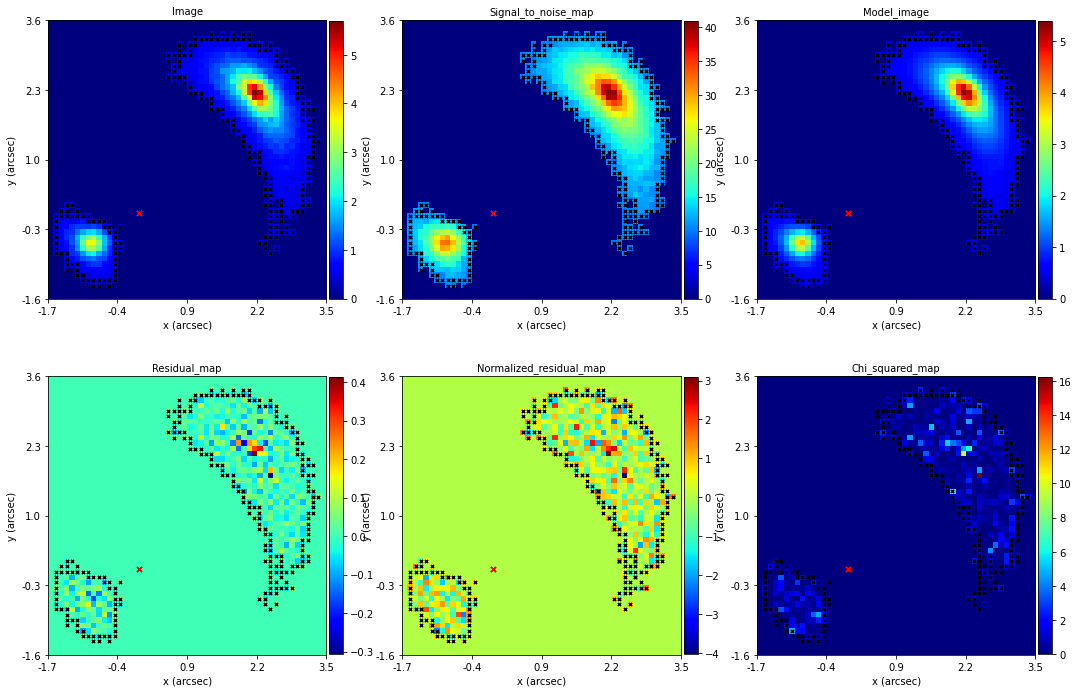

Log Likelihood with Regularization: 898.3437975326829
Log Evidence: 581.1296008694899
Log Likelihood : 1066.480031595932


In [7]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.50),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True,critical_curves=False,caustics=False))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)
print("Log Evidence:", fit.log_evidence)
print("Log Likelihood :", fit.log_likelihood)


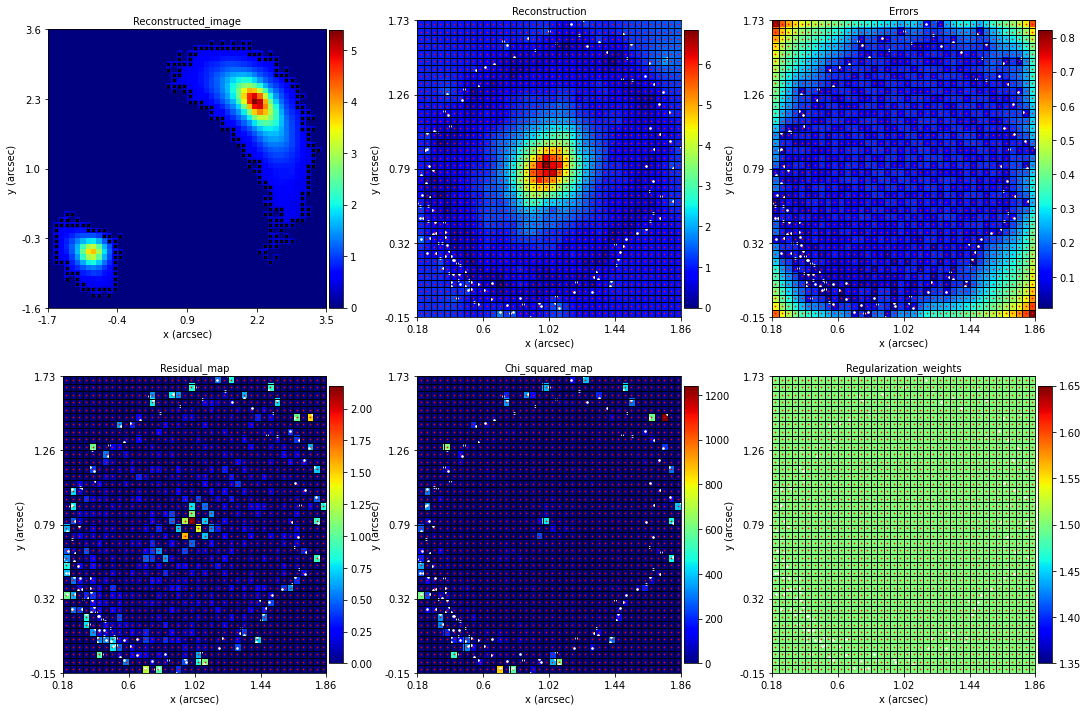

In [8]:
aplt.FitImaging.inversion_plots.subplot_inversion(inversion=fit.inversion, include=aplt.Include(mask=True,critical_curves=False,caustics=False))